In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")
plt.rcParams.update({'pdf.fonttype': 'truetype'})

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

In [3]:
from tabulate import tabulate

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend as K
import keras_tuner as kt

In [5]:
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(6, 6))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.fill_between(false_positive_rate, recall, color='r', alpha=0.025)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.show()
    
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0)
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(6, 6));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="Wistia", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()
    
def normalize(df, columns):
    for c in columns:
        df.loc[:, c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

Data Loading

In [6]:
df_users = pd.read_csv('users.csv', index_col='uid', parse_dates=['reg_date'])
df_users.shape

(8979, 6)

In [7]:
df_users.head()

,location,age,gender,reg_channel,reg_date,outcome
uid,,,,,,
0,15,17,female,3,2014-10-21,1
1,13,40,female,9,2006-05-26,0
2,14,23,male,9,2007-03-25,1
3,1,19,female,3,2014-11-02,1
4,1,0,NaN,9,2014-11-08,1


In [8]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8979 entries, 0 to 8978
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   location     8979 non-null   int64         
 1   age          8979 non-null   int64         
 2   gender       4681 non-null   object        
 3   reg_channel  8979 non-null   int64         
 4   reg_date     8979 non-null   datetime64[ns]
 5   outcome      8979 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 491.0+ KB


In [9]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
location,8979.0,6.591603,6.602242,1.0,1.0,4.0,13.0,22.0
age,8979.0,15.051231,18.008910,-43.0,0.0,18.0,27.0,810.0
reg_channel,8979.0,6.564874,2.244891,3.0,4.0,7.0,9.0,13.0
outcome,8979.0,0.507406,0.499973,0.0,0.0,1.0,1.0,1.0


In [10]:
df_users.isnull().sum()

location          0
age               0
gender         4298
reg_channel       0
reg_date          0
outcome           0
dtype: int64

In [11]:
df_users.isna().sum()

location          0
age               0
gender         4298
reg_channel       0
reg_date          0
outcome           0
dtype: int64

In [12]:
df_usage = pd.read_csv('usage_logs.csv', index_col='uid', parse_dates=['date']).drop(columns=['items'])
df_usage.shape

(2324214, 4)

In [13]:
df_usage.head()

,date,views,previews,duration
uid,,,,
1,2015-02-18,5,2,209
1,2015-04-12,12,3,376
1,2015-06-01,4,2,136
1,2015-07-22,12,17,562
1,2015-09-12,40,8,1021


In [14]:
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324214 entries, 1 to 8977
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   date      datetime64[ns]
 1   views     int64         
 2   previews  int64         
 3   duration  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 88.7 MB


In [15]:
df_usage.describe().T

,count,mean,std,min,25%,50%,75%,max
views,2324214.0,29.614033,39.820434,0.0,6.0,16.0,37.0,4446.0
previews,2324214.0,8.860921,17.574064,0.0,0.0,3.0,10.0,1597.0
duration,2324214.0,771.900893,871.820125,9.0,191.0,456.0,994.0,4228.0


In [16]:
positive = df_users['outcome'].sum()
positive

4556

In [17]:
pos = (positive/len(df_users))*100
round(pos, 2)

50.74

In [18]:
len(set(df_users.index).difference(set(df_usage.index)))

76

In [19]:
combined = df_users.join(df_usage.drop(columns='date').groupby('uid').agg('sum'), on='uid')
combined['reg_days'] = (combined['reg_date'].max() - combined['reg_date']).dt.days
combined.drop(columns=['reg_date'], inplace=True)
combined = pd.get_dummies(combined, columns=['gender'])

combined.head()

,location,age,reg_channel,outcome,views,previews,duration,reg_days,gender_female,gender_male
uid,,,,,,,,,,
0,15,17,3,1,2677.0,4600.0,86544.0,856,1,0
1,13,40,9,0,23010.0,7136.0,635905.0,3926,1,0
2,14,23,9,1,52578.0,5000.0,1325654.0,3623,0,1
3,1,19,3,1,5422.0,2072.0,145091.0,844,1,0
4,1,0,9,1,20754.0,7240.0,509117.0,838,0,0


In [20]:
x = combined[['location', 'age', 'reg_channel', 'reg_days', 'gender_female', 'gender_male']]
y = combined['outcome']

In [21]:
x = pd.get_dummies(x, columns=['reg_channel'])
x = pd.get_dummies(x, columns=['location'])

normalize(x, x.columns)

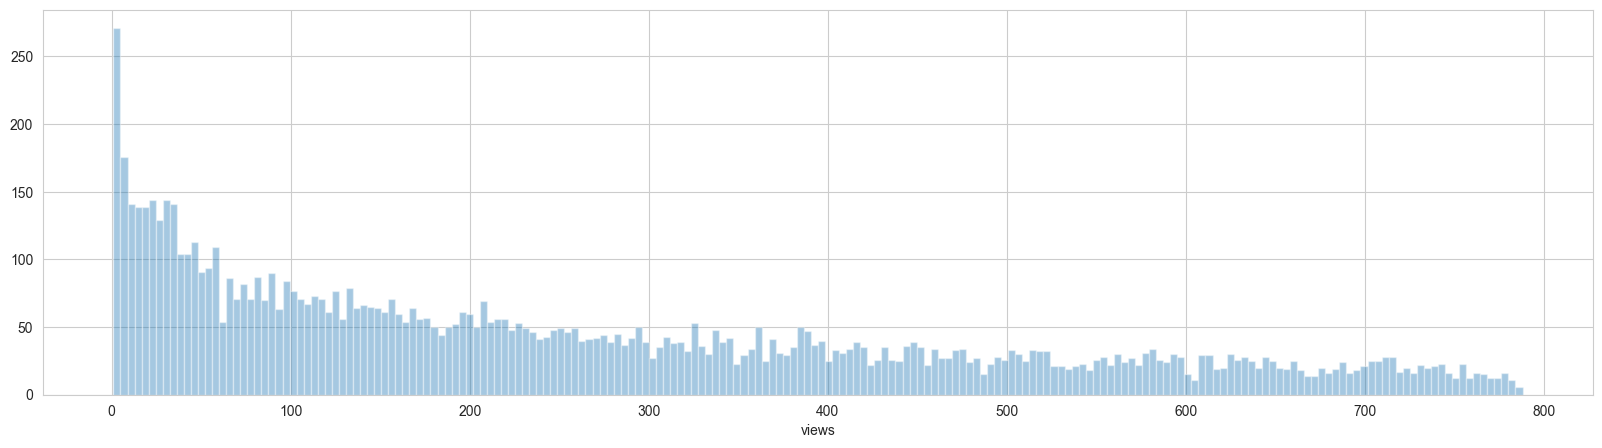

In [22]:
plt.figure(figsize=(20, 5));
sns.distplot(df_usage.groupby('uid').count()['views'], bins = 200, kde = False);

In [23]:
df_usage['timegap'] = -((df_usage['date'].max() - df_usage['date']).dt.days / 7).astype(int)
df_weekly = df_usage.groupby(['uid', 'timegap']).sum()
normalize(df_weekly, df_weekly.columns)

df_weekly.head()

views  previews  duration
uid time_bucket                              
0   -104         0.023578  0.053720  0.157096
    -103         0.018179  0.052284  0.118228
    -102         0.017999  0.053146  0.120695
    -101         0.009719  0.054582  0.071079
    -100         0.005040  0.041080  0.042958

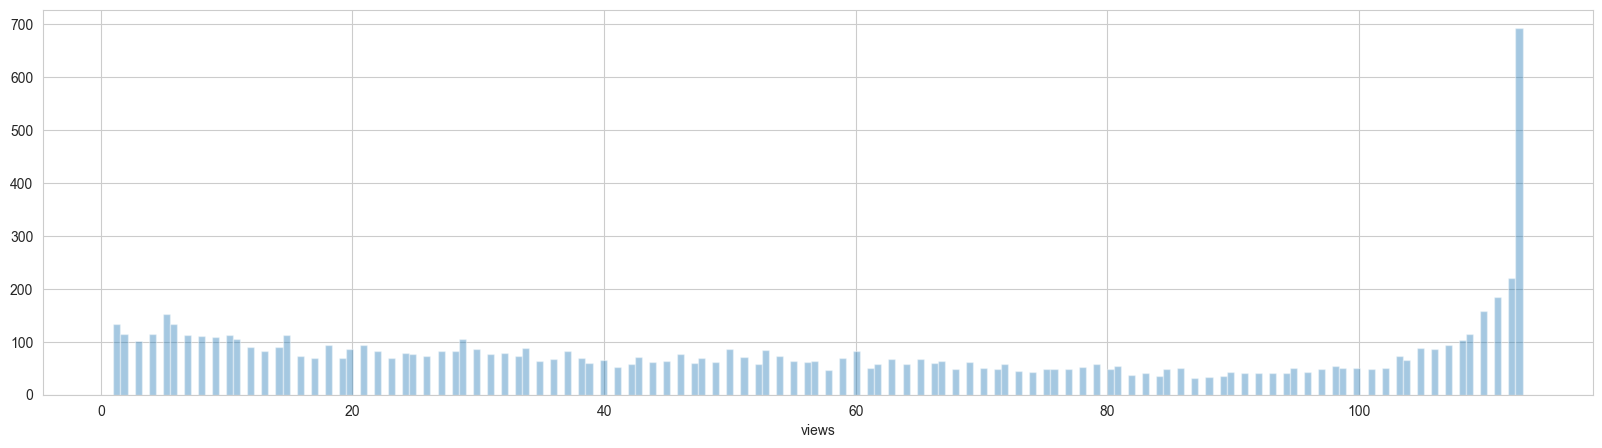

In [24]:
plt.figure(figsize=(20, 5));
sns.distplot(df_weekly.groupby('uid').count()['views'], bins = 200, kde = False);

Creating 3d tensors

In [25]:
ten3d = df_weekly.sort_values(['uid', 'timegap']).groupby('uid').apply(pd.DataFrame.to_numpy)
users = len(df_users)
events_per_user = df_weekly.groupby('uid').count()['views'].max()
n_features = len(df_weekly.columns)
x3d = np.zeros((users, events_per_user, n_features))
for uid in df_users.index:
    if uid in df_usage.index:
        n_events = min(events_per_user, len(ten3d[uid]))
        x3d[uid, -n_events:, :] = ten3d[uid][-n_events:, :]
        
print(f'x3d {x3d.shape}, x {x.shape}, y {y.shape}')

x3d (8979, 113, 3), x (8979, 30), y (8979,)


In [26]:
x3d_train, x3d_test, x_train, x_test, y_train, y_test = train_test_split(x3d, x, y, test_size = 0.25, random_state = 1)

LSTM Model

In [27]:
# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_outcome = Dense(1, activation='sigmoid')(dense_top_3)
model_lstm = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

In [29]:
# Model training
model_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm.fit([x3d_train, x_train], y_train, batch_size=16, epochs=100, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm.evaluate([x3d_test, x_test], y_test, verbose=0) 

Epoch 1/100
421/421 [==============================] - 12s 23ms/step - loss: 0.6163 - accuracy: 0.6749 - val_loss: 0.6104 - val_accuracy: 0.6828
Epoch 2/100
421/421 [==============================] - 10s 24ms/step - loss: 0.6111 - accuracy: 0.6783 - val_loss: 0.6056 - val_accuracy: 0.6806
Epoch 3/100
421/421 [==============================] - 10s 24ms/step - loss: 0.6055 - accuracy: 0.6792 - val_loss: 0.6026 - val_accuracy: 0.6837
Epoch 4/100
421/421 [==============================] - 12s 29ms/step - loss: 0.5966 - accuracy: 0.6862 - val_loss: 0.5835 - val_accuracy: 0.6956
Epoch 5/100
421/421 [==============================] - 12s 28ms/step - loss: 0.5787 - accuracy: 0.7049 - val_loss: 0.5618 - val_accuracy: 0.7152
Epoch 6/100
421/421 [==============================] - 9s 21ms/step - loss: 0.5627 - accuracy: 0.7170 - val_loss: 0.5566 - val_accuracy: 0.7184
Epoch 7/100
421/421 [==============================] - 10s 23ms/step - loss: 0.5561 - accuracy: 0.7177 - val_loss: 0.5523 - val_acc

In [30]:
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.5929076671600342
Test accuracy: 0.7175946831703186


71/71 [==============================] - 1s 6ms/step


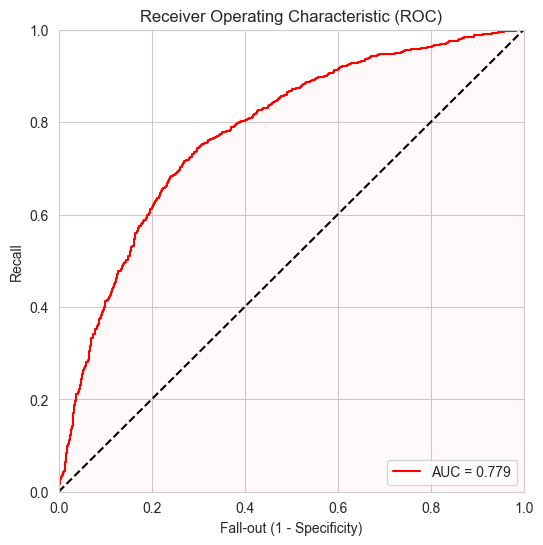

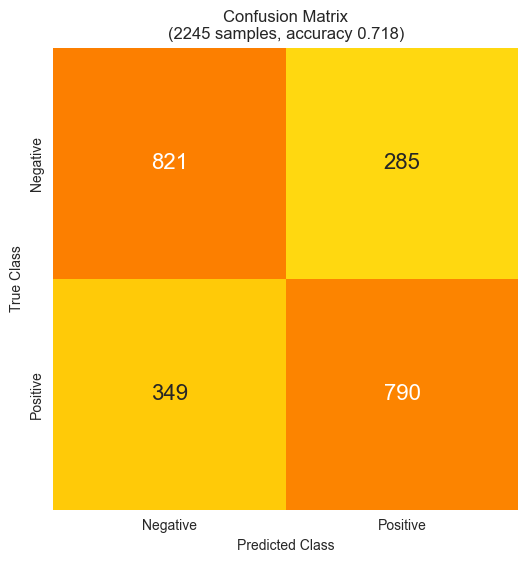

In [31]:
# Model evaluation
predictions_lstm_prob = model_lstm.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_prob)
plot_confusion_matrix(y_test, predictions_lstm_prob, ['Negative', 'Positive'])

In [32]:
with open('model_lstm.pkl', 'wb') as file:
    pickle.dump(model_lstm, file)

LSTM with Attention

In [33]:
# Model parameters
hidden_units = 8

# Model specification
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weights')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

lstm_tower = Model(inputs=input_logs, outputs=weighted_activations)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top = Dense(32, activation='relu')(combined)
prob_outcome = Dense(1, activation='sigmoid')(dense_top)
model_lstm_attention = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_outcome)

In [35]:
# Model training
model_lstm_attention.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model_lstm_attention.fit([x3d_train, x_train], y_train, batch_size=16, epochs=100, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model_lstm_attention.evaluate([x3d_test, x_test], y_test, verbose=0) 

Epoch 1/100
421/421 [==============================] - 13s 25ms/step - loss: 0.6250 - accuracy: 0.6611 - val_loss: 0.6148 - val_accuracy: 0.6706
Epoch 2/100
421/421 [==============================] - 9s 22ms/step - loss: 0.6135 - accuracy: 0.6739 - val_loss: 0.6070 - val_accuracy: 0.6819
Epoch 3/100
421/421 [==============================] - 9s 22ms/step - loss: 0.6093 - accuracy: 0.6806 - val_loss: 0.6053 - val_accuracy: 0.6822
Epoch 4/100
421/421 [==============================] - 9s 22ms/step - loss: 0.6077 - accuracy: 0.6819 - val_loss: 0.6033 - val_accuracy: 0.6861
Epoch 5/100
421/421 [==============================] - 9s 22ms/step - loss: 0.6057 - accuracy: 0.6813 - val_loss: 0.6009 - val_accuracy: 0.6871
Epoch 6/100
421/421 [==============================] - 9s 22ms/step - loss: 0.6039 - accuracy: 0.6843 - val_loss: 0.6003 - val_accuracy: 0.6861
Epoch 7/100
421/421 [==============================] - 9s 22ms/step - loss: 0.6021 - accuracy: 0.6856 - val_loss: 0.6202 - val_accuracy

In [36]:
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.6189523935317993
Test accuracy: 0.6779509782791138


71/71 [==============================] - 1s 5ms/step


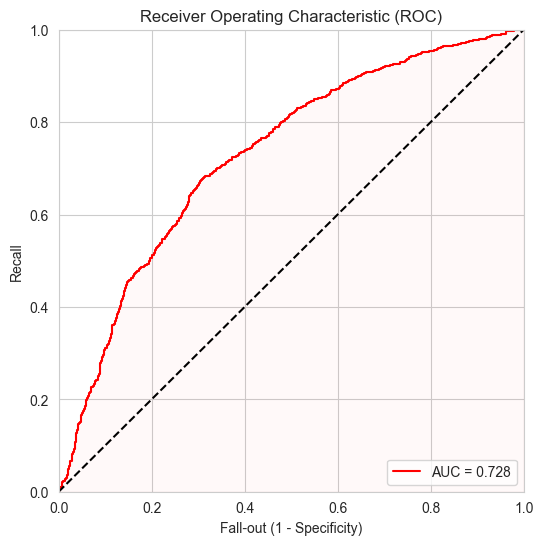

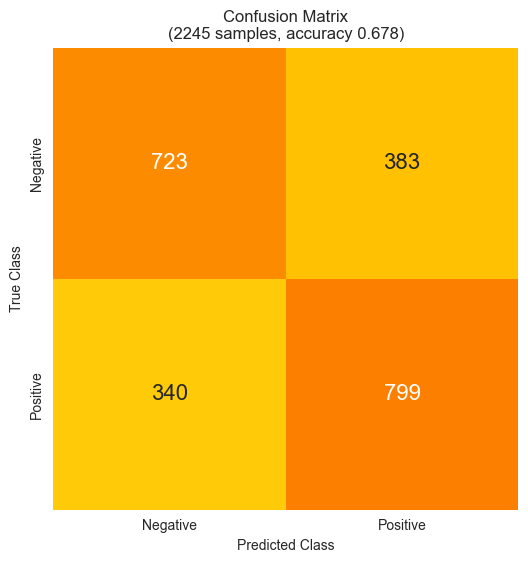

In [37]:
# Model evaluation
predictions_lstm_a_prob = model_lstm_attention.predict([x3d_test, x_test])
plot_roc(y_test, predictions_lstm_a_prob)
plot_confusion_matrix(y_test, predictions_lstm_a_prob, ['Negative', 'Positive'])

In [38]:
# Attention weights analysis

attention_model = Model(inputs=model_lstm_attention.input, outputs=model_lstm_attention.get_layer('attention_weights').output)
a = attention_model.predict([x3d_test, x_test])
print(f'Attention weights matrix: {a.shape[0]} users x {a.shape[1]} weights')

71/71 [==============================] - 1s 4ms/step
Attention weights matrix: 2245 users x 113 weights


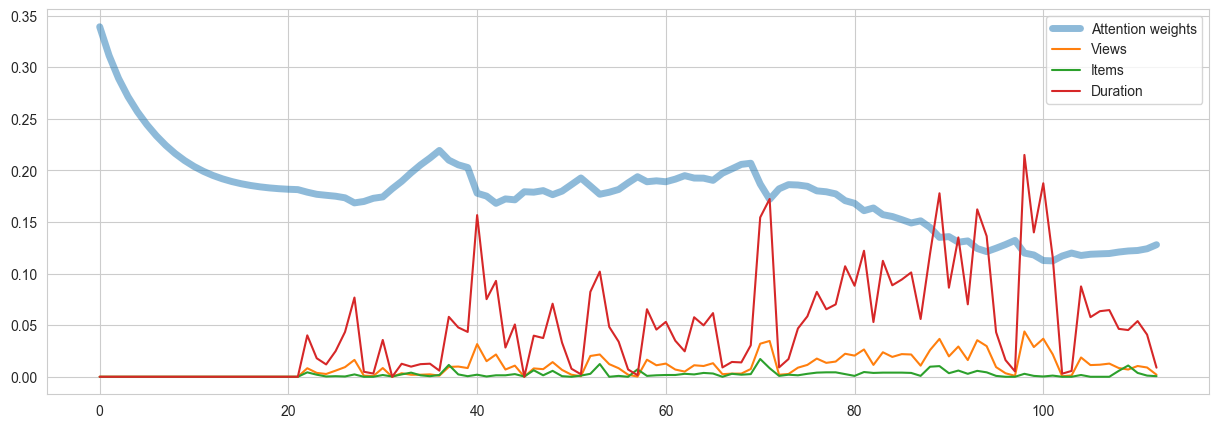

In [39]:
uid = 30
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(20 * a[uid, :], label='Attention weights', linewidth=5, alpha=0.5)
for i, column in zip(range(n_features), ['Views', 'Items', 'Duration', 'Previews']):
    ax.plot(x3d_test[uid][:, i], label=column)
ax.legend();

In [40]:
with open('model_lstm_attention.pkl', 'wb') as file:
    pickle.dump(model_lstm_attention, file)